In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
from matplotlib.gridspec import GridSpec

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
raw_path = './../../data/Raw/'

In [3]:
df_all = pd.DataFrame(columns=['uid', 
                               'time', 
                               'acc_status', 
                               'tweet_count',
                              'deletion_count'])

for file in Path(raw_path).glob('*'):
    df = pd.read_pickle(file)
    df_all = df_all.append(df, ignore_index=True)
    
df_all['acc_status'] = pd.to_numeric(df_all['acc_status'])
df_all['tweet_count'] = pd.to_numeric(df_all['tweet_count'])
df_all['time'] = pd.to_datetime(df_all['time'], format='%Y-%m-%d')
print(df_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32457183 entries, 0 to 32457182
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   uid             object        
 1   time            datetime64[ns]
 2   acc_status      int64         
 3   tweet_count     int64         
 4   deletion_count  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.2+ GB
None


In [4]:
df_active = df_all.loc[df_all['acc_status'] == 1]
df_1_all = df_active.groupby(['uid']).size().reset_index(name='count')

df_active['count_catg'] = 0;

for i in range(1, max(df_1_all['count'])+1):
    flag = df_active['uid'].isin(df_1_all.loc[df_1_all['count'] == i]['uid'])
    df_active.loc[flag,'count_catg'] = i
    
df_active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31726656 entries, 0 to 32457179
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   uid             object        
 1   time            datetime64[ns]
 2   acc_status      int64         
 3   tweet_count     int64         
 4   deletion_count  float64       
 5   count_catg      int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.7+ GB


#### Calculating estimated deletion count $C_{t+1}$ - $C_{t}$  <br /> $C_{t}$ = number of tweet count on day t

#### Those users who appear only one day are removed  from the consideration

In [5]:
#Function that shifts the tweet count data by one in time and subtracts the previous count from current count

def shift_and_subtract(x):
    x = x.sort_values(['time'])
    x['delay'] = (x['time'] - x['time'].shift(1)).dt.days
    
    #c_t+1 - c_t
    x['tweet_est_deleted'] = (x['tweet_count'] - x['tweet_count'].shift(1).fillna(0))
    
    #removes first day of data
    x = x.loc[x['time'] != min(x['time'])]
    
    return x

In [6]:
df_35 = df_active.loc[df_active['count_catg'] == 35]

print('Unique users count : ', len(df_35['uid'].unique()))
df_35.info()

Unique users count :  24616
<class 'pandas.core.frame.DataFrame'>
Int64Index: 861560 entries, 63 to 32456242
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   uid             861560 non-null  object        
 1   time            861560 non-null  datetime64[ns]
 2   acc_status      861560 non-null  int64         
 3   tweet_count     861560 non-null  int64         
 4   deletion_count  861536 non-null  float64       
 5   count_catg      861560 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 46.0+ MB


In [7]:
df_35 = df_35.groupby(['uid'], ).apply(shift_and_subtract).reset_index(drop=True)

In [8]:
df_35['user_cat'] = df_35['uid'].astype('category').cat.codes

In [9]:
df_35['deletion_count'] = - df_35['deletion_count']

In [10]:
df_35_median = df_35.groupby(['uid']).median().reset_index()

In [ ]:
# df_tweet_35['tweet_est_deleted'].replace({0: 1}, inplace=True)

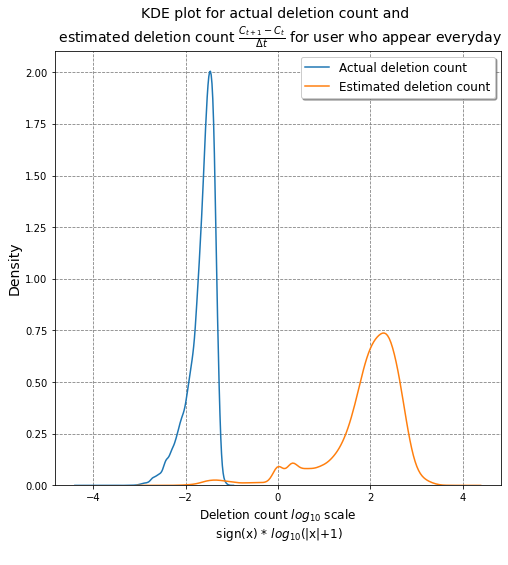

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

deletion_count = np.sign(df_35_median['deletion_count']) * np.log10(np.abs(df_35_median['deletion_count']) +1)

tweet_est_deleted = np.sign(df_35_median['tweet_est_deleted']) * np.log10(np.abs(df_35_median['tweet_est_deleted']) +1)

sns.kdeplot(deletion_count, label='Actual deletion count')
sns.kdeplot(tweet_est_deleted, label='Estimated deletion count')

plt.title('KDE plot for actual deletion count and \n estimated deletion count ' + r'$\frac{C_{t+1} - C_{t}}{\Delta t}$ for user who appear everyday',
         fontsize=14)

plt.ylabel('Density', fontsize=14)
plt.xlabel('Deletion count $log_{10}$ scale \n sign(x) * $log_{10}$(|x|+1) \n ',
          fontsize=12)

legend = ax.legend(loc='upper right', 
                   shadow=True, 
                   fontsize='large')

plt.grid(True, which='both', ls='--', c='gray')
# fig.savefig('distribution_35.png', facecolor='white', transparent=False)

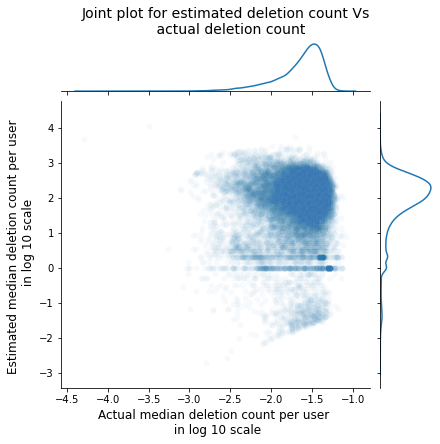

In [41]:
# fig, ax = plt.subplots(figsize=(8, 8))

title = 'Joint plot for estimated deletion count Vs \n actual deletion count'

g = sns.JointGrid(x=deletion_count, y=tweet_est_deleted)
g.plot_joint(sns.scatterplot,alpha=0.03)
g.plot_marginals(sns.kdeplot)

g.fig.suptitle(title, fontsize=14)
g.fig.subplots_adjust(top=0.9)


g.set_axis_labels(xlabel='Actual median deletion count per user \n in log 10 scale', 
       ylabel='Estimated median deletion count per user \n in log 10 scale',
       fontsize=12)

g.savefig('Jointplot_35.png', facecolor='white', transparent=False)
# ax.set_ylabel('Estimated deletion count in log 10 scale', fontsize=12)
# plt.grid(True, which='both', ls='--', c='gray')

### For users that do not appear every day

In [15]:
# df_active_no_1 = df_active.loc[df_active['count_catg'] != 1]

In [14]:
def shift_and_subtract_div_delay(x):
    x = x.sort_values(['time'])
    x['delay'] = (x['time'] - x['time'].shift(1)).dt.days
    
    #c_t+1 - c_t
    x['tweet_est_deleted'] = (x['tweet_count'] - x['tweet_count'].shift(1).fillna(0)) / x['delay']
    
    #removes first day of data
    x = x.loc[x['time'] != min(x['time'])]
    
    return x

In [ ]:
df_34 = df_active.loc[df_active['count_catg'] == 34]

In [ ]:
# min(df_34['time'])
# 1000045642679373824
# 999977720384638976
# df_34.groupby(['uid']).apply(lambda x: x.loc[x['time'] != '2021-05-01'])

In [ ]:
df_34 = df_34.groupby(['uid']).apply(shift_and_subtract_div_delay).reset_index(drop=True)

In [ ]:
df_34_median = df_34.groupby(['uid']).median().reset_index()

In [ ]:
df_34_median['deletion_count'] = - df_34_median['deletion_count']

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
i = 0
j = 0

fig.suptitle('KDE plot for actual deletion count and \n estimated deletion count ' + r'$\frac{C_{t+1} - C_{t}}{\Delta t}$ for users',
     fontsize=14)

fig.text(0.5, 
         0.01, 
         'Median Deletion count per user (log base 10 scale)',
         fontsize=15.0,
        ha='center')
fig.text(0.01, 
         0.5, 
         'Density', 
         va='center', 
         fontsize=15.0,
         rotation='vertical')

for category in [30, 31, 32, 33, 34, 35]:
    print(category)
    df_days = df_active.loc[df_active['count_catg'] == category]
#     df_days = df_days.sort_values('time')
    df_days = df_days.groupby(['uid']).apply(shift_and_subtract_div_delay).reset_index(drop=True)
    
    df_days_median = df_days.groupby(['uid']).median().reset_index()
    
    ax[i, j].set_title('Users who appear '+ str(category) + ' days')
    
    df_days_median['deletion_count'] = - df_days_median['deletion_count']
    
    deletion_count = np.sign(df_days_median['deletion_count']) * np.log10(np.abs(df_days_median['deletion_count']) +1)

    tweet_est_deleted = np.sign(df_days_median['tweet_est_deleted']) * np.log10(np.abs(df_days_median['tweet_est_deleted']) +1)
    
    sns.kdeplot(deletion_count, 
                label='Actual median deletion count',
               ax=ax[i, j])
    sns.kdeplot(tweet_est_deleted, 
                label='Estimated median deletion count',
               ax=ax[i, j])
    handles, labels = ax[i, j].get_legend_handles_labels()
    
    ax[i,j].set_xlabel('')
    
#     legend = ax[i, j].legend(loc='upper right', 
#                    shadow=True, 
#                    fontsize='large')
    j = j + 1
    
    if j == 3:
        j = 0
        i = i + 1

        
fig.tight_layout(pad=4.0)
fig.legend(handles, labels, loc='upper right')
fig.savefig('30_35_distribution.png', facecolor='white', transparent=False)

In [ ]:
title = 'Joint plot for estimated deletion count Vs \n actual deletion count'

g = sns.JointGrid(x=deletion_count, y=tweet_est_deleted)
g.plot_joint(sns.scatterplot,alpha=0.01)
g.plot_marginals(sns.kdeplot)

g.fig.suptitle(title, fontsize=14)
g.fig.subplots_adjust(top=0.9)


g.set_axis_labels(xlabel='Actual deletion count in log 10 scale', 
       ylabel='Estimated deletion count in log 10 scale',
       fontsize=12)

# g.savefig('Jointplot_35.png', facecolor='white', transparent=False)

In [ ]:
k = df_mean['50%'].sort_values(ascending = False)

unique, counts = np.unique(k, return_counts=True)

sum_all = sum(counts)

cdf = counts[::-1].cumsum()[::-1]/sum_all

cdf = np.round(cdf,3)


l = df_merged['actual_deletion'].sort_values(ascending = False)

l_u, l_c = np.unique(l, return_counts=True)

sum_all_l = sum(l_c)

cdf_2 = l_c[::-1].cumsum()[::-1]/sum_all_l

cdf_2 = np.round(cdf_2,3)
fig, ax = plt.subplots(figsize=(13, 10))
ax.step(unique, cdf, label='Estimated number of deletions')
ax.step(l_u, cdf_2, label='Actual number of deletions')
plt.grid(True, which='both', ls='--', c='gray')
plt.xscale('symlog', linthresh=1, subs=[2, 3, 4, 5, 6, 7, 8, 9])

legend = ax.legend(loc='upper right', 
                   shadow=True, 
                   fontsize='medium')

xlabel= 'Median number of deletion count per user in symmetrical log scale' \
' \n Estimated number of deletions = $C_{t+1}$ - $C_{t}$ \n' \
' $C_{t}$ = tweet count on day t'

plt.title('CCDF for estimated and actual number of deletions',
         fontsize=18)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel(xlabel,
          fontsize=14)

plt.show()

fig.savefig('ccdf_35_estimate.png')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# sns.kdeplot(df_merged['50%'], color='r', label='median')
# sns.kdeplot(df_merged['actual_deletion'], label='actual')
ax.scatter(df_merged['50%'], df_merged['actual_deletion'], alpha=0.1)
plt.xscale('symlog')
plt.yscale('symlog', linthresh=1,)
plt.xlim(min(df_merged['50%']))
plt.title('Scatterplot Median estimated deletion count Vs Median actual deletion count')

plt.ylabel('Median actual deletion count per user', fontsize=14)
plt.xlabel('Median estimated deletion count per user \n symmetrical log scale, linear range (-1, 1)',
          fontsize=14)

# legend = ax.legend(loc='upper right', 
#                    shadow=True, 
#                    fontsize='large')
fig.savefig('scatter_35_estimate.png')

In [ ]:

# fig = plt.figure()
# gs = GridSpec(10, 10)

# ax_hist_y = fig.add_subplot(gs[0:6,6:10])
# ax_scatter = fig.add_subplot(gs[1:6, 0:6])

# ax_hist_x = fig.add_subplot(gs[1:10, 6:10])

# plt.show()

 ### Minimum New Tweets Added:
**tweet_count_for_day_1 + x_number_of_tweet_added_between_day_1_and_2  - number_of_deletions_in_day_2  = tweet_count_for_day_2


<br />Affected by lag of data collection
<br />Some values in -ve which would mean, we do not know how many they added but they deleted more than added
<br />Number of tweet added can be more than 2400 (Tweet limit for a day is 2400 , Twitter Policy), this would mean they added data in previous day as well as time before we queried API (Maximum added can be 4800).


In [ ]:
df_35_added = df_active.loc[df_active['count_catg'] == 35]
# df_active_pivot_2000_tweet['num_added'] = - df_active_pivot_2000_tweet['num_tweets'].shift(1).fillna(0) + df_active_pivot_2000_tweet['num_tweets'] + df_active_pivot_2000_tweet['num_deletions']

In [ ]:
df_35_added = df_active.loc[df_active['count_catg'] == 35]

def estimated_added(x):
    x = x.sort_values(['time'])
    x['tweet_est_added'] = x['tweet_count'] - x['tweet_count'].shift(1).fillna(0) + x['deletion_count']
    
    return x
    
df_35_added = df_35_added.groupby(['uid'], as_index=False).apply(estimated_added).reset_index()
df_35_added = df_35_added.drop(['level_0', 'level_1'], axis=1)
df_35_added = df_35_added.loc[df_35_added['time'] != min(df_35_added['time'])]

df_35_added_median = df_35_added.groupby(['uid']).median().reset_index()

df_35_added_median.info()

In [ ]:
max(df_35_added_median['tweet_est_added'])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.ecdfplot(df_35_added_median['tweet_est_added'], 
             color='r', 
             label='Estimated tweet added',
            complementary=True)

sns.ecdfplot(df_35_added_median['deletion_count'], 
             label='Deleted tweet count',
            complementary=True)

# sns.kdeplot(df_merged['actual_deletion'], label='actual')
# ax.scatter(df_merged['50%'], df_merged['actual_deletion'], alpha=0.1)
# plt.xscale('symlog', linthresh=1,)
# plt.yscale('symlog', linthresh=1,)

plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Median estimated tweet count per user \n **$C_{t}$ + $\Delta$$C_{t-(t+1)}$ - $D_{t+1}$ = $C_{t+1}$',
          fontsize=14)

plt.grid(True, which='both', ls='--', c='gray')
plt.xscale('symlog', linthresh=1, subs=[2, 3, 4, 5, 6, 7, 8, 9])


legend = ax.legend(loc='upper right', 
                   shadow=True, 
                   fontsize='small')

fig.savefig('ccdf_35_estimate_added.png', facecolor='white', transparent=False)

In [ ]:
df_35_added_median.loc[df_35_added_median['tweet_est_added'] > 4800]


# $\frac{C_{t+1} - C_{t}}{2400 * (\Delta t + 1)}$